Import library

In [3]:
import pandas as pd
import numpy as np
from datetime import date
from google.colab import drive

Mount Google Drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Open datasets

In [5]:
appearances_df = pd.read_csv('/content/drive/MyDrive/Data245/Project/Datasets/appearances.csv')
players_df = pd.read_csv('/content/drive/MyDrive/Data245/Project/Datasets/players.csv')
clubs_df = pd.read_csv('/content/drive/MyDrive/Data245/Project/Datasets/clubs.csv')
competitions_df = pd.read_csv('/content/drive/MyDrive/Data245/Project/Datasets/competitions.csv')
valuations_df = pd.read_csv('/content/drive/MyDrive/Data245/Project/Datasets/player_valuations.csv')
# will be using GDP instead of year because year is continuous value and keep increasing so it is not a good feature
# using GDP to imply inflation
gdp_df = pd.read_csv('/content/drive/MyDrive/Data245/Project/Datasets/uk_gdp_usd.csv')

GDP

In [6]:
# convert GDP to trillion scale and round to 2 decimal places
gdp_df['GDP_USD'] = round(gdp_df['GDP_USD'].div(10**12), 2)
# rename column year
gdp_df = gdp_df.rename(columns={'year': 'gdp_year'})
# rename column GDP_USD
gdp_df = gdp_df.rename(columns={'GDP_USD': 'gdp_usd_in_trillion'})

Appearances

In [7]:
# pre-process appearances table
appearances_df = appearances_df.drop(['player_pretty_name', 'game_id', 'appearance_id', 
                                      'competition_id', 'player_club_id'], axis=1)
# convert date to year only
appearances_df['date'] = pd.to_datetime(appearances_df['date'])
# group by player id and appearance year and sum up others
appearances_df= appearances_df.groupby(by=[appearances_df.player_id, appearances_df.date.dt.year]).sum().reset_index()
# rename column date
appearances_df = appearances_df.rename(columns={'date': 'appearance_year'})

Clubs

In [8]:
# pre-process clubs table
clubs_df = clubs_df[['club_id', 'total_market_value']]
# will need to adjust fillna(#) for better accuracy
# fill null values with 1 which mean the club total market value is worth 1 million.
clubs_df['total_market_value'] = clubs_df['total_market_value'].fillna(1)
# rename column total market value
clubs_df = clubs_df.rename(columns={'total_market_value': 'club_total_market_value_in_million'})

<ipython-input-8-e104f4b75bd0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clubs_df['total_market_value'] = clubs_df['total_market_value'].fillna(1)


Competitions

In [9]:
# pre-process competition table
competitions_df = competitions_df[['domestic_league_code']]
# group by domestic league code
competitions_df = competitions_df.groupby(competitions_df['domestic_league_code'], as_index=False).last()

Player Valuations

In [10]:
# pre-process player_valuations table
valuations_df = valuations_df[['player_id', 'date', 'market_value']]
# convert date to year
valuations_df['date'] = pd.to_datetime(valuations_df['date'])
# group by player_id and year to get average market_value 
valuations_df = valuations_df.groupby(by=[valuations_df.player_id, valuations_df.date.dt.year]).mean().reset_index()
# convert market value to million scale and round to 2 decimal places
valuations_df['market_value'] = round(valuations_df['market_value'].div(10**6), 2)
# rename column date
valuations_df = valuations_df.rename(columns={'date': 'market_year'})
# rename column market value
valuations_df = valuations_df.rename(columns={'market_value': 'market_value_in_million'})

Players

In [11]:
# pre-process players table
# convert date_of_birth to year
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth']).dt.year
players_df = players_df[['player_id', 'date_of_birth', 'country_of_birth', 'position', 'sub_position', 
                         'foot', 'height_in_cm', 'club_id', 'domestic_competition_id']]
# drop row that has null value on date_of_birth column
players_df.dropna(inplace=True, subset=['date_of_birth'])
# fill null value in column contry_of_birth with N/A
players_df['country_of_birth'].fillna('N/A', inplace=True)
# fill null value in column sub_position with N/A
players_df['sub_position'].fillna('N/A', inplace=True)
# fill null value in column foot with N/A
players_df['foot'].fillna('N/A', inplace=True)
# rename column date_of_birth
players_df = players_df.rename(columns={'date_of_birth': 'year_of_birth'})
# rename column domestic_competition_id
players_df = players_df.rename(columns={'domestic_competition_id': 'domestic_league_code'})

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Use One Hot Encoding to convert categorical type to number

Categorical columns in players table: country_of_birth, position, sub_position, foot, domestic_competition_id

In [12]:
# one hot encoding using pandas get_dummies on specific column
def one_hot_encoding(df_col, col_name):
    unique_arr = df_col.unique()
    # add N/A to unique array
    if 'N/A' not in unique_arr:
        unique_arr = np.append(unique_arr, ['N/A'])
    # create a new df for unique array
    new_df = pd.DataFrame(unique_arr, columns=[col_name])
    # generate dummies columns
    dummies_df = pd.get_dummies(new_df)
    # concatenate new df and dummies df
    new_df = pd.concat([new_df, dummies_df], axis=1)
    return new_df

In [13]:
n = 20
# get the top n countries that occur the most in player country_of_birth column
top_n_s = players_df['country_of_birth'].value_counts().head(n)
# create a new dataframe for top n countries
top_n_df = pd.DataFrame({'country_of_birth': top_n_s.index})

In [14]:
# change value of country_of_birth column to N/A if it is not in top n countries
new_country_col = players_df['country_of_birth'].apply(lambda x: x if x in top_n_s.index else 'N/A')
new_players_df = players_df
new_players_df['country_of_birth'] = new_country_col

In [15]:
# one hot encoding for domestic league code
domestic_league_code_df = one_hot_encoding(competitions_df['domestic_league_code'], 'domestic_league_code')
# one hot encoding for player position
position_df = one_hot_encoding(players_df['position'], 'position')
# one hot encoding for player sub-position
sub_position_df = one_hot_encoding(players_df['sub_position'], 'sub_position')
# one hot encoding for player foot
foot_df = one_hot_encoding(players_df['foot'], 'foot')
# one hot encoding for player country of birth
country_of_birth_df = one_hot_encoding(new_players_df['country_of_birth'], 'country_of_birth')

In [16]:
# join dummies df into players df
new_players_df = players_df.merge(position_df, on='position', how='left')
new_players_df = new_players_df.merge(sub_position_df, on='sub_position', how='left')
new_players_df = new_players_df.merge(foot_df, on='foot', how='left')
new_players_df = new_players_df.merge(domestic_league_code_df, on='domestic_league_code', how='left')
new_players_df = new_players_df.merge(country_of_birth_df, on='country_of_birth', how='left')
# remove categorical columns after one hot encoding
new_players_df.drop(['position', 'sub_position', 'foot', 'domestic_league_code', 'country_of_birth'], 
                    axis=1, inplace=True)

Join multiple tables together

In [17]:
# join valuations df with gdp df on year column
new_valuations_df = valuations_df.merge(gdp_df, left_on='market_year', right_on='gdp_year')
new_valuations_df = new_valuations_df.drop(['gdp_year'], axis=1)
# join new player df with clubs df
processed_df = new_players_df.merge(clubs_df, on='club_id')
# join processed df with new valuations df
processed_df = processed_df.merge(new_valuations_df, on='player_id')
# add a new column for age at the time of market evaluation
processed_df['evaluation_age'] = processed_df['market_year'] - processed_df['year_of_birth']
# join processed df with apperances df
processed_df = processed_df.merge(appearances_df, left_on=['player_id', 'market_year'], 
                                  right_on=['player_id', 'appearance_year'])

In [18]:
# remove unimportant columns/features
processed_df.drop(['player_id', 'year_of_birth', 'club_id', 'market_year', 'appearance_year'], axis=1, inplace=True)

In [19]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63975 entries, 0 to 63974
Data columns (total 67 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   height_in_cm                        63975 non-null  int64  
 1   position_Attack                     63975 non-null  uint8  
 2   position_Defender                   63975 non-null  uint8  
 3   position_Goalkeeper                 63975 non-null  uint8  
 4   position_Midfield                   63975 non-null  uint8  
 5   position_N/A                        63975 non-null  uint8  
 6   sub_position_Attacking Midfield     63975 non-null  uint8  
 7   sub_position_Central Midfield       63975 non-null  uint8  
 8   sub_position_Centre-Back            63975 non-null  uint8  
 9   sub_position_Centre-Forward         63975 non-null  uint8  
 10  sub_position_Defensive Midfield     63975 non-null  uint8  
 11  sub_position_Left Midfield          63975

In [20]:
processed_df

,height_in_cm,position_Attack,position_Defender,position_Goalkeeper,position_Midfield,position_N/A,sub_position_Attacking Midfield,sub_position_Central Midfield,sub_position_Centre-Back,sub_position_Centre-Forward,...,country_of_birth_Ukraine,club_total_market_value_in_million,market_value_in_million,gdp_usd_in_trillion,evaluation_age,goals,assists,minutes_played,yellow_cards,red_cards
0,164,1,0,0,0,0,0,0,0,0,...,0,15.71,0.50,3.09,28.0,1,0,105,0,0
1,164,1,0,0,0,0,0,0,0,0,...,0,15.71,0.40,2.96,29.0,0,0,28,0,0
2,168,1,0,0,0,0,0,0,0,1,...,0,15.71,0.18,2.96,22.0,0,1,43,1,0
3,180,1,0,0,0,0,0,0,0,1,...,0,15.71,0.90,2.96,27.0,0,0,371,2,0
4,180,1,0,0,0,0,0,0,0,1,...,0,15.71,0.81,2.72,28.0,0,0,56,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63970,179,0,0,0,1,0,0,0,0,0,...,0,10.33,4.05,2.76,22.0,0,1,630,3,0
63971,179,0,0,0,1,0,0,0,0,0,...,0,10.33,3.60,2.88,21.0,0,0,2,0,0
63972,179,0,0,0,1,0,0,0,0,0,...,0,10.33,2.34,3.19,24.0,1,1,606,1,0
63973,174,1,0,0,0,0,1,0,0,0,...,0,10.33,0.54,3.19,20.0,0,0,232,1,0


In [21]:
# save processed df to csv file
processed_df.to_csv('/content/drive/MyDrive/Data245/Project/Datasets/processed_data.csv', index=False)

### **Random Forest Regression**

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
input = processed_df.drop('market_value_in_million', axis=1)
output = processed_df['market_value_in_million']
# normalization
stdsc = StandardScaler()
input.iloc[:, :] =stdsc.fit_transform(input.iloc[:, :])

Split data into training, testing dataset

In [24]:
input_train, input_test, output_train, output_test = train_test_split(input,output,test_size=0.2, random_state=42)

Hyperparameter tuning

In [25]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
#                                n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
# rf_random.fit(input_train, output_train)

Find&use best parameters

In [27]:
# print ('Best Parameters: ', rf_random.best_params_, ' \n')

In [28]:
forest = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=90, bootstrap=True)
forest.fit(input_train, output_train)

RandomForestRegressor(max_depth=90)

In [29]:
train_pred = forest.predict(input_train)
r2 = r2_score(output_train, train_pred)
r2

0.960225555658285

The top 10 highest importance score for features

In [30]:
importance = forest.feature_importances_
df = pd.DataFrame({'feature': input_train.columns, 'importance': importance})
df = df.sort_values('importance', ascending=False).head(10)
print(df)

                               feature  importance
58  club_total_market_value_in_million    0.382499
63                      minutes_played    0.147737
61                               goals    0.115047
62                             assists    0.060458
60                      evaluation_age    0.057904
59                 gdp_usd_in_trillion    0.049813
0                         height_in_cm    0.035178
64                        yellow_cards    0.024154
26            domestic_league_code_FR1    0.012680
42            country_of_birth_England    0.006164


Text(0, 0.5, '')

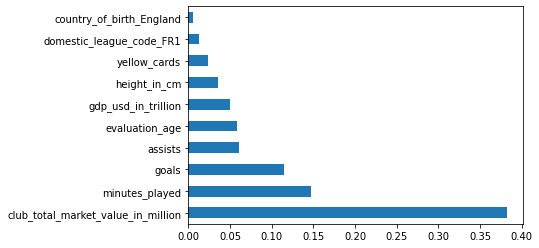

In [31]:
ax = df.plot(kind='barh', x='feature', legend=False)
ax.set_ylabel('')

Evaluation metrics

In [32]:
output_pred = forest.predict(input_test)
r2 = r2_score(output_test, output_pred)
mse = mean_squared_error(output_test, output_pred)
mae = mean_absolute_error(output_test, output_pred)
rmse = mean_squared_error(output_test, output_pred, squared=False)

In [33]:
print('mean absolute error: %12.4f' % mae)
print('mean squared error: %14.4f' % mse)
print('root mean squared error: %8.4f' % rmse)
print('r^2: %28.4f' % r2)

mean absolute error:       1.8015
mean squared error:        16.3369
root mean squared error:   4.0419
r^2:                       0.7168
